In [9]:







































































!pip install split-folders


In [2]:
!pip install pydot


In [76]:
!pip install torch torchvision pretrainedmodels torchsummary


In [13]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.0 MB/s eta 0:05:22
   ---------------------------------------- 0.8/332.0 MB 1.1 MB/s eta 0:05:12
   ---------------------------------------- 1.0/332.0 MB 1.1 MB/s eta 0:04:56
   ---------------------------------------- 1.3/332.0 MB 1.2 MB/s eta 0:04:45
   ---------------------------------------- 1.6/332.0 MB 1.2 MB/s eta 0:04:32
   ---------------------------------------- 2.1/332.0 MB 1.3 MB/s eta 0:04:13
   ---------------------------------------- 2.4/332.0 MB 1.3 MB/s eta 0:04:05
   ---------------------------------------- 2.6/332.0 MB 1.3 MB/s eta 0:04:05
   ---------------------------------------- 2.9/332.0 MB 1.3 MB/s eta 0:04:06
   ---------------------------------------- 3.1/332.0 MB 1.3 MB/s eta 0:04:11
   ----

Classes : ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Healthy : 522 images
Mosaic : 462 images
RedRot : 518 images
Rust : 514 images
Yellow : 505 images


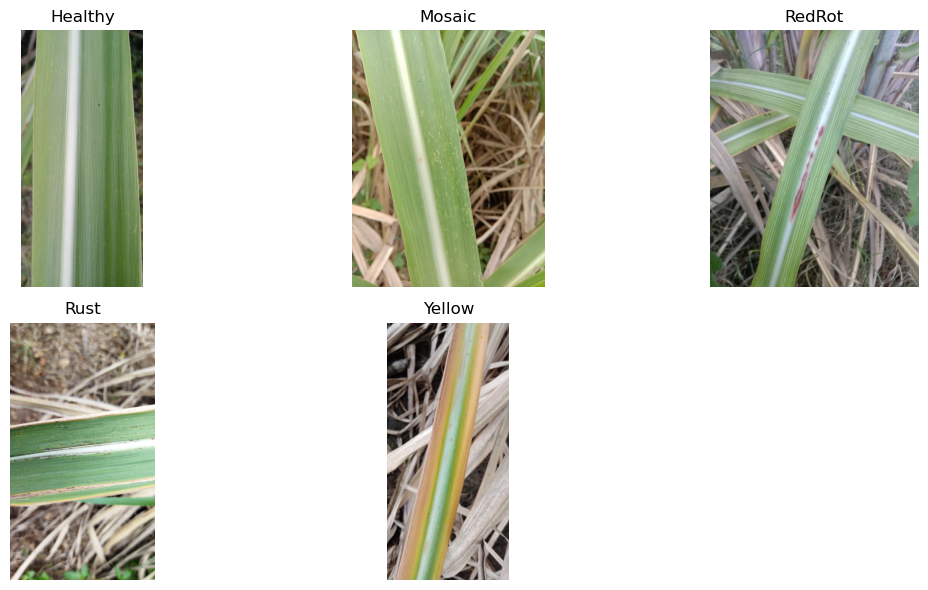

In [45]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math

base_dir = "C:\\Users\\isiPr\\Desktop\\SugarcaneLeafDiseaseDataset"
classes = os.listdir(base_dir)
print("Classes :", classes)

for c in classes:
    print(c, ":", len(os.listdir(os.path.join(base_dir, c))), "images")

num_classes = len(classes)
cols = 3  # nombre de colonnes
rows = math.ceil(num_classes / cols)  # nombre de lignes

plt.figure(figsize=(12, 6))
for i, c in enumerate(classes):
    img_path = os.path.join(base_dir, c, random.choice(os.listdir(os.path.join(base_dir, c))))
    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [46]:
import splitfolders

splitfolders.ratio(base_dir, output="data_split", seed=42, ratio=(0.7, 0.15, 0.15))


Copying files: 2521 files [00:16, 151.93 files/s]


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # ← AJOUT ICI
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input    # ← AJOUT ICI
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input    # ← AJOUT ICI
)

train_gen = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    'data_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1762 images belonging to 5 classes.
Found 376 images belonging to 5 classes.
Found 384 images belonging to 5 classes.


In [80]:
import pandas as pd

class_counts = {c: len(os.listdir(os.path.join(base_dir, c))) for c in classes}
df = pd.DataFrame(list(class_counts.items()), columns=['Classe', 'Nombre d’images'])
print(df)


    Classe  Nombre d’images
0  Healthy              522
1   Mosaic              462
2   RedRot              518
3     Rust              514
4   Yellow              505


In [82]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [106]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# On gèle les couches pour ne pas réentraîner toute la base
for layer in base_model.layers:
    layer.trainable = False


In [107]:
# =========================================
# 1️⃣ SE block + tête finale (inchangée)
# =========================================
x = base_model.output

# --- SE block ---
se = GlobalAveragePooling2D()(x)
se = Dense(256, activation='relu')(se)
se = Dense(x.shape[-1], activation='sigmoid')(se)
se = Reshape((1,1,x.shape[-1]))(se)
x = Multiply()([x, se])

# --- tête finale ---
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [108]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [109]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,164,421 (95.99 MB)

 Trainable params: 1,576,709 (6.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [110]:
#for layer in base_model.layers[-30:]:  # On "dégèle" les 30 dernières couches
  #  layer.trainable = True
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4608 - loss: 1.7552 - val_accuracy: 0.7021 - val_loss: 1.3224
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6913 - loss: 1.2993 - val_accuracy: 0.7713 - val_loss: 1.0990
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7577 - loss: 1.1175 - val_accuracy: 0.7846 - val_loss: 0.9899
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7940 - loss: 0.9978 - val_accuracy: 0.8005 - val_loss: 0.9224
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8224 - loss: 0.9038 - val_accuracy: 0.8191 - val_loss: 0.8780
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8456 - loss: 0.8392 - val_accuracy: 0.8351 - val_loss: 0.8128
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8729 - loss: 0.7700 - val_accuracy: 0.8378 - val_loss: 0.8245
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8774 - loss: 0.7472 - val_accuracy: 0.8590 - val_loss:

In [111]:
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 997ms/step - accuracy: 0.8464 - loss: 0.7732
Test accuracy: 0.8463541865348816


In [112]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # IMPORTANT : LR TRÈS BAS
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [113]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================
# 1️⃣  Définir les callbacks
# =========================================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # arrête si val_loss ne s’améliore plus après 3 epochs
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',           # le fichier du meilleur modèle sauvegardé
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

# =========================================
# 2️⃣  LANCER L’ENTRAÎNEMENT AVEC CALLBACKS
# =========================================

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,                # EarlyStopping stoppera automatiquement
    callbacks=callbacks,      
    verbose=1
)



Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7946 - loss: 0.9425  
Epoch 1: val_loss improved from None to 0.69754, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8178 - loss: 0.8757 - val_accuracy: 0.8750 - val_loss: 0.6975
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8820 - loss: 0.7278  
Epoch 2: val_loss improved from 0.69754 to 0.68453, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8814 - loss: 0.7177 - val_accuracy: 0.8803 - val_loss: 0.6845
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9084 - loss: 0.6484  
Epoch 3: val_loss improved from 0.68453 to 0.67239, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9115 - loss: 0.6450 - val_accuracy: 0.8856 - val_loss: 0.6724
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9111 - loss: 0.6262  
Epoch 4: val_loss improved from 0.67239 to 0.65278, saving mod

In [114]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

loss, acc = model.evaluate(test_gen)
print("Final test accuracy:", acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 947ms/step - accuracy: 0.9271 - loss: 0.5771
Final test accuracy: 0.9270833134651184


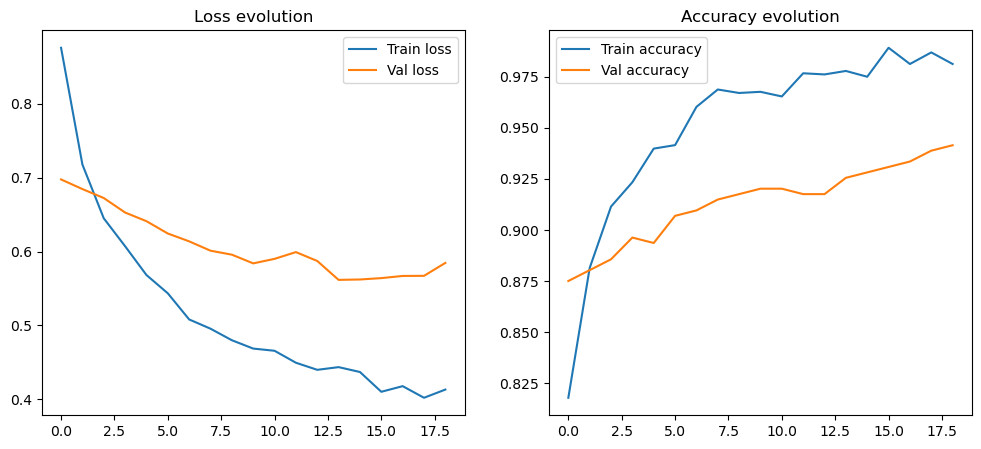

In [115]:
plt.figure(figsize=(12,5))

# LOSS
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss evolution")

# ACCURACY
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title("Accuracy evolution")

plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step  


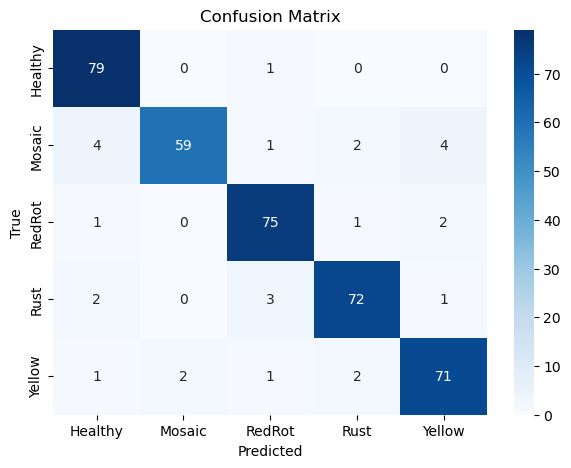

              precision    recall  f1-score   support

     Healthy       0.91      0.99      0.95        80
      Mosaic       0.97      0.84      0.90        70
      RedRot       0.93      0.95      0.94        79
        Rust       0.94      0.92      0.93        78
      Yellow       0.91      0.92      0.92        77

    accuracy                           0.93       384
   macro avg       0.93      0.92      0.93       384
weighted avg       0.93      0.93      0.93       384



In [116]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=class_names))


In [117]:
model.save("best_model.keras")


In [119]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model2.trainable = False  # on gèle les couches pour le transfer learning


In [120]:
num_classes = train_gen.num_classes

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=base_model2.input, outputs=output)


In [121]:
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [122]:
history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.2474 - loss: 1.6775 - val_accuracy: 0.4521 - val_loss: 1.3751
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3485 - loss: 1.4689 - val_accuracy: 0.5505 - val_loss: 1.2363
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4308 - loss: 1.3726 - val_accuracy: 0.5798 - val_loss: 1.1450
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4847 - loss: 1.2735 - val_accuracy: 0.6197 - val_loss: 1.0717
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5176 - loss: 1.2109 - val_accuracy: 0.6250 - val_loss: 1.0184
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5227 - loss: 1.1819 - val_accuracy: 0.6383 - val_loss: 0.9813
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5568 - loss: 1.1441 - val_accuracy: 0.6543 - val_loss: 0.9404
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5692 - loss: 1.0959 - val_accuracy: 0.6676 - val_loss:

In [124]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint('best_model2.keras', monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

callbacks = [earlystop, checkpoint, reduce_lr]

# Fine-tuning
base_model2.trainable = True
for layer in base_model2.layers[:-50]:
    layer.trainable = False

# Compilation
model2.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement
history2_ft = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4817 - loss: 1.2525    
Epoch 1: val_loss improved from None to 0.82522, saving model to best_model2.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5465 - loss: 1.1793 - val_accuracy: 0.7021 - val_loss: 0.8252 - learning_rate: 5.0000e-05
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6214 - loss: 1.0401  
Epoch 2: val_loss improved from 0.82522 to 0.75789, saving model to best_model2.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6413 - loss: 0.9893 - val_accuracy: 0.7287 - val_loss: 0.7579 - learning_rate: 5.0000e-05
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6859 - loss: 0.8960    
Epoch 3: val_loss improved from 0.75789 to 0.69937, saving model to best_model2.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6958 - loss: 0.8688 - val_accuracy: 0.7420 - val_loss: 0.6994 - learning_rate: 5.0000e-05
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

In [125]:
loss2, acc2 = model2.evaluate(test_gen)
print("Test accuracy EfficientNetB0:", acc2)


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 798ms/step - accuracy: 0.8750 - loss: 0.4057
Test accuracy EfficientNetB0: 0.875


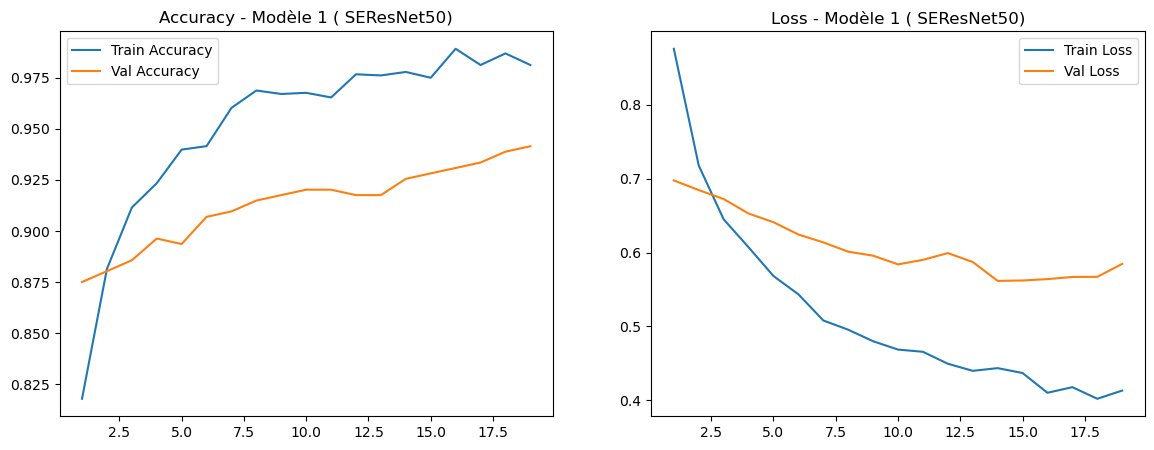

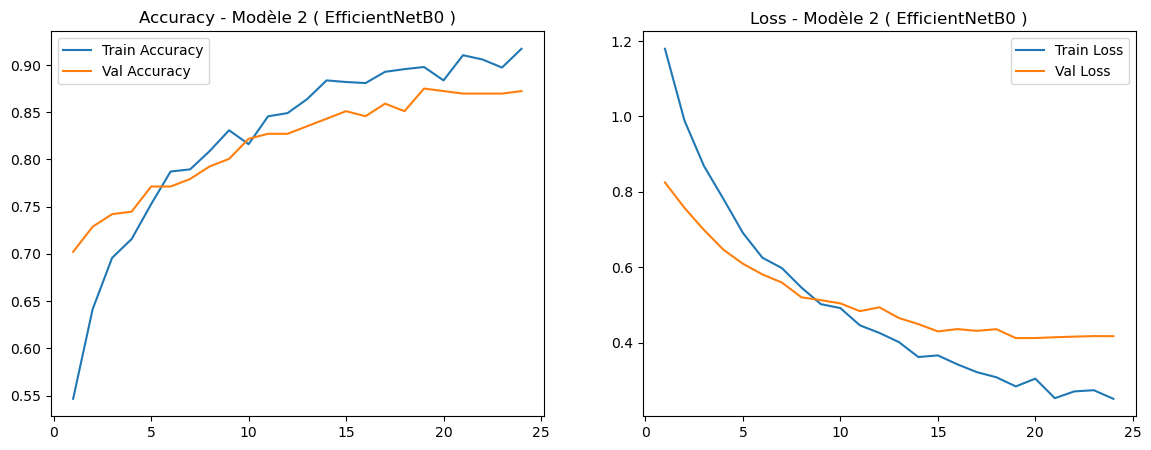

In [126]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'Loss - {title}')
    plt.legend()

    plt.show()

# Remplace ici par tes vrais objets history
plot_history(history, "Modèle 1 ( SEResNet50)")
plot_history(history2_ft, "Modèle 2 ( EfficientNetB0 )")


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


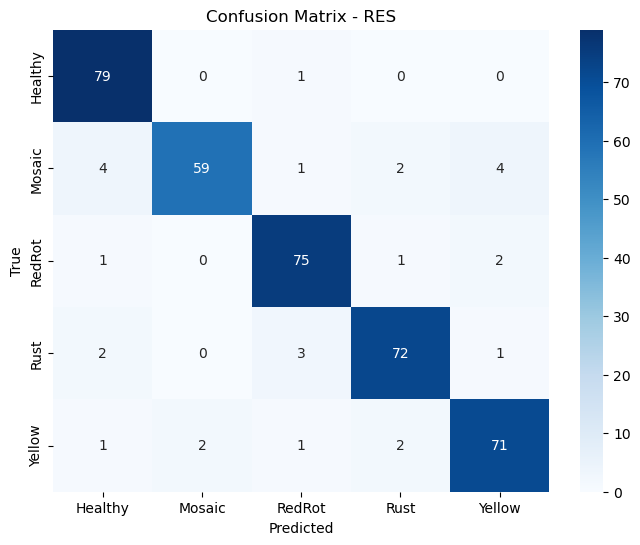


Classification Report :

              precision    recall  f1-score   support

     Healthy       0.91      0.99      0.95        80
      Mosaic       0.97      0.84      0.90        70
      RedRot       0.93      0.95      0.94        79
        Rust       0.94      0.92      0.93        78
      Yellow       0.91      0.92      0.92        77

    accuracy                           0.93       384
   macro avg       0.93      0.92      0.93       384
weighted avg       0.93      0.93      0.93       384



In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Vrai labels
y_true = test_gen.classes

# Prédictions du modèle 
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Noms des classes
class_names = list(test_gen.class_indices.keys())

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RES")
plt.show()

print("\nClassification Report :\n")
print(classification_report(y_true, y_pred, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 817ms/step


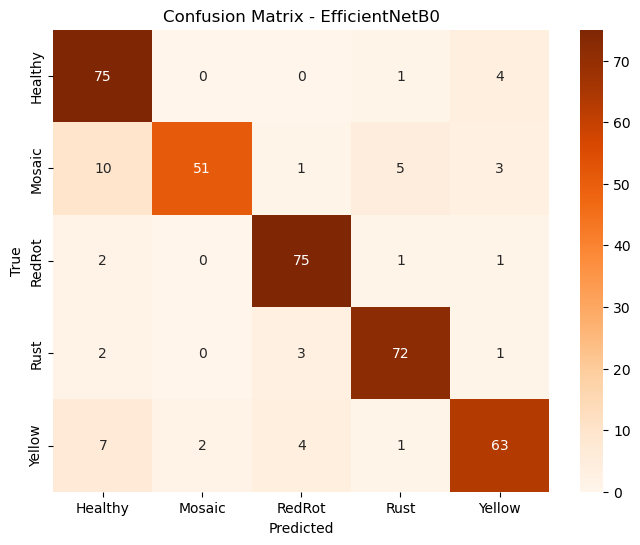


Classification Report :

              precision    recall  f1-score   support

     Healthy       0.78      0.94      0.85        80
      Mosaic       0.96      0.73      0.83        70
      RedRot       0.90      0.95      0.93        79
        Rust       0.90      0.92      0.91        78
      Yellow       0.88      0.82      0.85        77

    accuracy                           0.88       384
   macro avg       0.88      0.87      0.87       384
weighted avg       0.88      0.88      0.87       384



In [128]:
y_pred2 = np.argmax(model2.predict(test_gen), axis=1)

cm2 = confusion_matrix(y_true, y_pred2)

plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()

print("\nClassification Report :\n")
print(classification_report(y_true, y_pred2, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step 


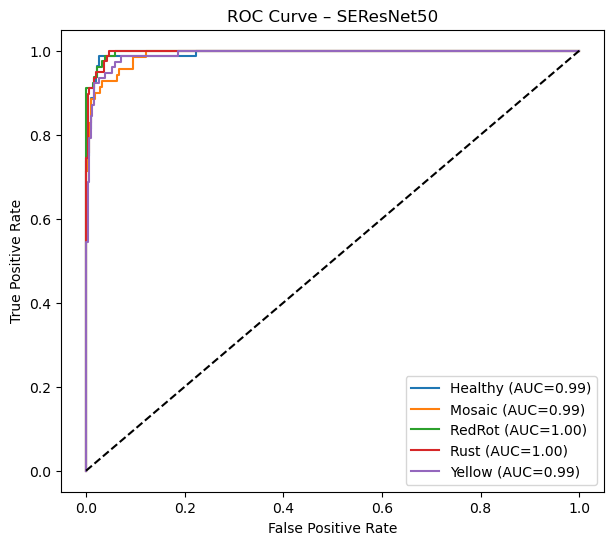

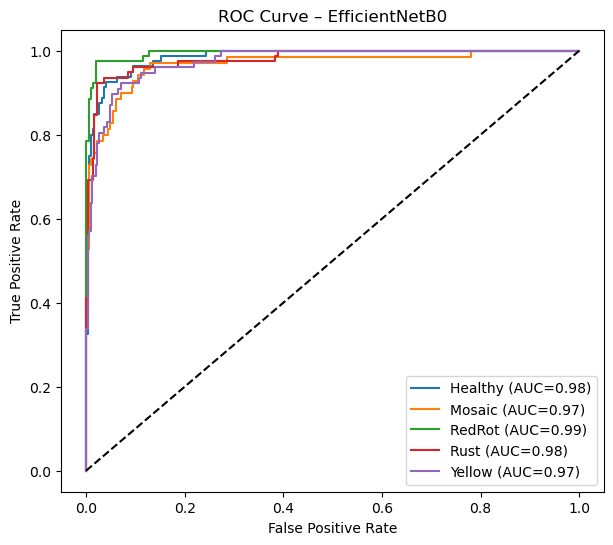

In [130]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
# Binariser les labels

class_names = sorted(os.listdir("data_split/train"))
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Prédictions probas
probs1 = model.predict(test_gen)
probs2 = model2.predict(test_gen)

def plot_roc(probs, title):
    plt.figure(figsize=(7,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

plot_roc(probs1, "ROC Curve – SEResNet50")
plot_roc(probs2, "ROC Curve – EfficientNetB0")


In [132]:
from tensorflow.keras.models import load_model
import os
import numpy as np
from PIL import Image
import io

# Charger ton meilleur modèle
model = load_model("best_model.keras")

# Récupérer les classes depuis le dossier split
class_names = sorted(os.listdir("data_split/train"))

print("Classes chargées :", class_names)


Classes chargées : ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [133]:
from tensorflow.keras.applications.resnet import preprocess_input

def preprocess_image(img_bytes):
    img = Image.open(img_bytes).convert("RGB")
    img = img.resize((224, 224))

    img = np.array(img)
    img = preprocess_input(img)   # ⬅ IMPORTANT !
    img = np.expand_dims(img, axis=0)

    return img, Image.open(img_bytes).resize((224, 224))


In [135]:
import ipywidgets as widgets
from IPython.display import display

out = widgets.Output()

def upload_change(change):
    with out:
        out.clear_output()

        if uploader.value:
            value = uploader.value

            # Compatibilité Colab + Jupyter
            if isinstance(value, dict):          # COLAB
                file_info = list(value.values())[0]
            elif isinstance(value, tuple):       # JUPYTER
                file_info = value[0]
            else:
                print("Format inattendu :", type(value))
                return

            file_content = file_info['content']

            # Prétraitement
            x, img = preprocess_image(io.BytesIO(file_content))

            # Prediction
            preds = model.predict(x)
            predicted_index = np.argmax(preds)
            predicted_name = class_names[predicted_index]

            display(img)
            print(" Prédiction :", predicted_name)

# Widget d’upload
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(upload_change, names='value')

display(widgets.HTML("<h3>Uploader une image :</h3>"))
display(uploader)
display(out)


HTML(value='<h3>Uploader une image :</h3>')

FileUpload(value=(), accept='image/*', description='Upload')

Output()